In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
import torchvision.models as models
#from tensorflow import keras
#from keras.applications import VGG16
import os
from torchvision.transforms import v2
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
os.environ["TOKENIZERS_PARALLELISM"] = "true"
# %env CUDA_LAUNCH_BLOCKING=1
import random
import torch.optim.lr_scheduler as lr_scheduler
import pandas as pd
from PIL import Image
import torchvision

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [3]:
#model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)

In [4]:
model_2 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

In [5]:
model_2

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
im_ca = pd.read_csv('results.csv', sep='|', names=['image','number', 'caption'], skiprows=1)

In [7]:
im_ca.drop('number', axis=1, inplace=True)

In [8]:
im_ca

,image,caption
0,1000092795.jpg,Two young guys with shaggy hair look at their...
1,1000092795.jpg,"Two young , White males are outside near many..."
2,1000092795.jpg,Two men in green shirts are standing in a yard .
3,1000092795.jpg,A man in a blue shirt standing in a garden .
4,1000092795.jpg,Two friends enjoy time spent together .
...,...,...
158910,998845445.jpg,A man in shorts and a Hawaiian shirt leans ov...
158911,998845445.jpg,"A young man hanging over the side of a boat ,..."
158912,998845445.jpg,A man is leaning off of the side of a blue an...
158913,998845445.jpg,"A man riding a small boat in a harbor , with ..."


In [9]:
annotations = {}
for index, row in im_ca.iterrows():
    img_id = row['image']
    caption = row['caption']
    
    if isinstance(caption, str):
        caption = caption.strip()
        
        if img_id in annotations:
            annotations[img_id].append(caption)
        else:
            annotations[img_id] = [caption]

annotations

{'1000092795.jpg': ['Two young guys with shaggy hair look at their hands while hanging out in the yard .',
  'Two young , White males are outside near many bushes .',
  'Two men in green shirts are standing in a yard .',
  'A man in a blue shirt standing in a garden .',
  'Two friends enjoy time spent together .'],
 '10002456.jpg': ['Several men in hard hats are operating a giant pulley system .',
  'Workers look down from up above on a piece of equipment .',
  'Two men working on a machine wearing hard hats .',
  'Four men on top of a tall structure .',
  'Three men on a large rig .'],
 '1000268201.jpg': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A little girl in a pink dress going into a wooden cabin .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl climbing into a wooden playhouse',
  'A girl going into a wooden building .'],
 '1000344755.jpg': ['Someone in a blue shirt and hat is standing on stair and leaning against

In [10]:
for key, captions in annotations.items():
    for i, caption in enumerate(captions):  
        captions[i] = caption.lower()
        captions[i] = re.sub(r'[^a-z\s]', '', captions[i])
        captions[i] = re.sub(r'\s+', ' ', captions[i])
        captions[i] = ' '.join(word for word in captions[i].split() if len(word) > 2)
        captions[i] = captions[i].strip()



In [11]:
annotations

{'1000092795.jpg': ['two young guys with shaggy hair look their hands while hanging out the yard',
  'two young white males are outside near many bushes',
  'two men green shirts are standing yard',
  'man blue shirt standing garden',
  'two friends enjoy time spent together'],
 '10002456.jpg': ['several men hard hats are operating giant pulley system',
  'workers look down from above piece equipment',
  'two men working machine wearing hard hats',
  'four men top tall structure',
  'three men large rig'],
 '1000268201.jpg': ['child pink dress climbing set stairs entry way',
  'little girl pink dress going into wooden cabin',
  'little girl climbing the stairs her playhouse',
  'little girl climbing into wooden playhouse',
  'girl going into wooden building'],
 '1000344755.jpg': ['someone blue shirt and hat standing stair and leaning against window',
  'man blue shirt standing ladder cleaning window',
  'man ladder cleans the window tall building',
  'man blue shirt and jeans ladder cl

In [12]:
from transformers import AutoTokenizer

In [13]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", add_special_tokens=True, padding=True, truncation=True, max_length=30, return_tensors="pt")

In [14]:
tokenizer.vocab_size

30522

In [15]:
'''for keys, values in img_cap.items():
    img_cap[keys] = tokenizer(values, padding='max_length', max_length=max_length, truncation=True)['input_ids']'''

"for keys, values in img_cap.items():\n    img_cap[keys] = tokenizer(values, padding='max_length', max_length=max_length, truncation=True)['input_ids']"

In [16]:
max_length = 30

In [17]:
'''img_features = []
img_captions_tokenized = []

for img_name, captions in tqdm(img_cap.items()):
    # Load and transform the image
    img_path = os.path.join(IMAGE_DIR + 'Images/' + img_name + '.jpg')
    
    image = transform(image)
    img_features.append(image)
    encoded_captions = [tokenizer.encode(caption, add_special_tokens=True,
                                         max_length=max_length, padding='max_length',
                                         truncation=True) for caption in captions]
    img_captions_tokenized.append(encoded_captions)'''

"img_features = []\nimg_captions_tokenized = []\n\nfor img_name, captions in tqdm(img_cap.items()):\n    # Load and transform the image\n    img_path = os.path.join(IMAGE_DIR + 'Images/' + img_name + '.jpg')\n    \n    image = transform(image)\n    img_features.append(image)\n    encoded_captions = [tokenizer.encode(caption, add_special_tokens=True,\n                                         max_length=max_length, padding='max_length',\n                                         truncation=True) for caption in captions]\n    img_captions_tokenized.append(encoded_captions)"

In [18]:

'''img_features = np.array(img_features)
img_features = torch.tensor(img_features)
img_features.shape'''
#X = torch.stack(repeat_img_features)
#y = torch.tensor(flattened_captions)

#X.shape, y.shape
#train_dataset = torch.utils.data.TensorDataset(X, y)
#train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

'img_features = np.array(img_features)\nimg_features = torch.tensor(img_features)\nimg_features.shape'

In [19]:
def train_test_split(data, split_ratio=0.9):
    data_items = list(data.items())
    random.shuffle(data_items)
    num_train = int(len(data_items) * split_ratio)
    train_data = dict(data_items[:num_train])
    test_data = dict(data_items[num_train:])
    return train_data, test_data

train_data, test_data = train_test_split(annotations, split_ratio=0.9)

In [20]:
#len(train_data), len(test_data)

In [21]:
#save_in = imagename_caption['1000092795.jpg']
#save_in

In [22]:
'''img_features = []
img_captions = []
directory = os.path.join(IMAGE_DIR + 'Images')
for img_name in tqdm(os.listdir(directory)):
    img_pth = (os.path.join(directory + '/' + img_name))
    img = cv2.imread(img_pth)
    img = cv2.resize(img, (224, 224))
    img_features.append(img)
    img_captions.append(img_cap[img_name])'''


"img_features = []\nimg_captions = []\ndirectory = os.path.join(IMAGE_DIR + 'Images')\nfor img_name in tqdm(os.listdir(directory)):\n    img_pth = (os.path.join(directory + '/' + img_name))\n    img = cv2.imread(img_pth)\n    img = cv2.resize(img, (224, 224))\n    img_features.append(img)\n    img_captions.append(img_cap[img_name])"

In [23]:
'''features_array = np.array(img_features)
features_caption_array = np.array(img_captions)'''

'features_array = np.array(img_features)\nfeatures_caption_array = np.array(img_captions)'

In [24]:
#X = torch.tensor(features_array).permute(0, 3, 1, 2)
#y = torch.tensor(features_caption_array)

In [57]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class Flickr30kDataset(Dataset):
    def __init__(self, annotations, tokenizer, max_length, transform=None):
        self.annotations = annotations
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        img_id = list(self.annotations.keys())[idx]
        img_filename = img_id
        
        img_path = os.path.join('flickr30k_images/', img_filename)
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
        
        captions = self.annotations[img_id]
        
        caption = torch.tensor(self.tokenizer.encode(captions[torch.randint(len(captions), (1,)).item()], 
                                                      add_special_tokens=True,
                                                      max_length=self.max_length, 
                                                      padding='max_length', 
                                                      truncation=True))
        
        return image, caption
    
transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToImage(),
    v2.ToDtype(torch.float, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
batch_size = 64

In [58]:
train_dataset = Flickr30kDataset(train_data, tokenizer, max_length, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [157]:
test_dataset = Flickr30kDataset(test_data, tokenizer, max_length, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [60]:
img_path = os.path.join('flickr30k_images/', '1000268201.jpg')
image = cv2.imread(img_path)
image = cv2.resize(image, (300, 300))
        
        
captions = annotations['1000268201.jpg']
        
caption = ((captions[torch.randint(len(captions), (1,)).item()], 
                                                      ))
print(caption)

('little girl climbing the stairs her playhouse',)


In [61]:
for batch_idx, (images, captions) in enumerate(train_dataloader):
    print(images)
    print(captions)
    break

tensor([[[[ 1.0502,  1.0502,  1.0502,  ...,  1.0331,  1.0159,  0.9817],
          [ 1.2043,  1.2043,  1.2043,  ...,  1.0844,  1.0673,  1.0502],
          [ 1.2043,  1.1872,  1.1872,  ...,  1.1015,  1.0844,  1.0844],
          ...,
          [-0.1828, -0.1657, -0.1657,  ..., -0.2856, -0.2856, -0.2856],
          [-0.1657, -0.1999, -0.1486,  ..., -0.3198, -0.3369, -0.3027],
          [-0.1828, -0.1999, -0.2171,  ..., -0.3541, -0.3369, -0.2684]],

         [[ 0.8529,  0.8354,  0.8529,  ...,  0.9230,  0.9055,  0.9230],
          [ 1.0105,  1.0280,  1.0105,  ...,  0.9755,  0.9580,  0.9580],
          [ 1.0105,  0.9930,  1.0105,  ...,  1.0105,  0.9755,  0.9755],
          ...,
          [-0.5651, -0.5476, -0.5301,  ..., -0.6527, -0.6527, -0.6527],
          [-0.5476, -0.6001, -0.5826,  ..., -0.6352, -0.6527, -0.6527],
          [-0.5826, -0.6176, -0.6702,  ..., -0.6527, -0.6176, -0.5826]],

         [[ 1.1062,  1.1411,  1.1585,  ...,  1.1934,  1.1759,  1.1934],
          [ 1.2631,  1.2805,  

In [62]:
class EncoderImage(nn.Module):
    def __init__(self, model, embed_size, cnn_train = False):
        super(EncoderImage, self).__init__()
        self.train_model = model
        self.train_model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1024)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc_1 = nn.Linear(1024, 512)
        self.fc_2 = nn.Linear(512, embed_size)
        self.cnn_train = cnn_train

    def forward(self, x):
        x = self.train_model(x) 
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc_2(x)
        
        for name, param in self.train_model.named_parameters():
            if 'classifier.1.weight' in name or 'classifier.1.bias' in name:
                param.requires_grad = True
            else:
                param.requires_grad = self.cnn_train

        return x

In [63]:
class EncoderImageResnet(nn.Module):
    def __init__(self, model, embed_size, cnn_train = False):
        super(EncoderImageResnet, self).__init__()
        self.train_model = model
        self.train_model.fc = nn.Linear(self.train_model.fc.in_features, 256)
        self.cnn_train = cnn_train

    def forward(self, x):
        x = self.train_model(x) 
        
        for name, param in self.train_model.named_parameters():
            if 'fc' in name:
                param.requires_grad = True
            else:
                param.requires_grad = self.cnn_train

        return x

In [64]:
class LuongAttention(nn.Module):
    def __init__(self, hidden_size):
        super(LuongAttention, self).__init__()
        self.hidden_size = hidden_size
        self.attention = nn.Linear(hidden_size, hidden_size)

    def forward(self, hidden_state, encoder_output):
        attention_scores = torch.bmm(encoder_output, self.attention(hidden_state).unsqueeze(2)).squeeze(2)
        attention_weights = torch.nn.functional.softmax(attention_scores, dim=1)
        context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_output).squeeze(1)
        return context_vector, attention_weights

In [65]:
class DecoderText(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(DecoderText, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.4)
        self.relu = nn.ReLU()

    def forward(self, captions, features):
        embed = self.embed(captions)
        embed = self.dropout(embed)
        embed = torch.cat((features.unsqueeze(1), embed), dim=1)
        lstm_out, _ = self.lstm(embed)
        out = self.fc_1(lstm_out)
        return out

In [66]:
class DecoderTextWithLuong(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1):
        super(DecoderTextWithLuong, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.luong = LuongAttention(hidden_size)
        self.fc = nn.Linear(hidden_size*2, vocab_size)


    def forward(self, captions, features, length=max_length):
        embed = self.embed(captions)
        embed = torch.cat((features.unsqueeze(1), embed), dim=1)
        lstm_out, _ = self.lstm(embed)
        context_vector, _ = self.luong(lstm_out[:, -1, :], lstm_out[:, :-1, :])
        context_vector = context_vector.unsqueeze(1).repeat(1, lstm_out.size(1), 1)
        concatenated_input = torch.cat((lstm_out, context_vector), dim=2)
        outputs = self.fc(concatenated_input)
        return outputs

In [67]:
class EncoderDecoder(nn.Module):
    def __init__(self, model, embed_size, vocab_size, hidden_size, num_layers=1, cnn_train = False):
        super(EncoderDecoder, self).__init__()
        self.encoder = EncoderImage(model, embed_size)
        self.decoder = DecoderText(vocab_size, embed_size, hidden_size, num_layers)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(captions, features)

        return outputs

In [68]:
class EncoderDecoderWithAttention(nn.Module):
    def __init__(self, model, embed_size, vocab_size, hidden_size, num_layers=1, cnn_train = False):
        super(EncoderDecoderWithAttention, self).__init__()
        self.encoder = EncoderImageResnet(model, embed_size)
        self.decoder = DecoderTextWithLuong(vocab_size, embed_size, hidden_size, num_layers)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(captions, features)

        return outputs

In [69]:
#HYPERPARAMETERS
embed_size = 256
hidden_size = 512
num_layers = 1
vocab_size = tokenizer.vocab_size
learning_rate = 0.001


In [70]:
device

device(type='cuda')

In [71]:
#final_model = EncoderDecoder(model, embed_size, vocab_size, hidden_size, num_layers).to(device)

In [72]:
#final_model

In [73]:
'''X_train = X[:int(len(X)*0.9)]
y_train = y[:int(len(y)*0.9)]
X_test = X[int(len(X)*0.9):]
y_test = y[int(len(y)*0.9):]'''

'X_train = X[:int(len(X)*0.9)]\ny_train = y[:int(len(y)*0.9)]\nX_test = X[int(len(X)*0.9):]\ny_test = y[int(len(y)*0.9):]'

In [74]:
'''X_train.shape, y_train.shape, X_test.shape, y_test.shape'''

'X_train.shape, y_train.shape, X_test.shape, y_test.shape'

In [75]:
#train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
#test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

In [76]:
#train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
#test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [77]:
model_resnet = EncoderDecoderWithAttention(model_2, embed_size, vocab_size, hidden_size, num_layers).to(device)

In [78]:
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=learning_rate)

In [79]:
criterion_resnet = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer_resnet = torch.optim.Adam(model_resnet.parameters(), lr=learning_rate)

In [80]:
#scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

In [81]:
torch.cuda.empty_cache()


In [82]:
torch.cuda.memory_allocated()

669984256

In [83]:
model_resnet

EncoderDecoderWithAttention(
  (encoder): EncoderImageResnet(
    (train_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [84]:
#final_model.load_state_dict(torch.load('imagecaptiongen/upgradedd_model_dict.pth'))

In [140]:
#Training Model
import nltk
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

#nltk.download('punkt')
num_epochs = 5
model_resnet.train()
running_loss = 0
total_loss = 0
total_references = []  
total_hypotheses = []  
batch_bleu_scores = []
total_bleu_per_batch = []
for epoch in range(num_epochs):
    for batch_idx, (images, captions) in enumerate(tqdm(train_dataloader, unit='batch', desc=f'Epoch: {epoch+1}')):
        images = images.to(device)
        captions = captions.to(device)
        outputs = model_resnet(images, captions[:, :-1])
        loss = criterion_resnet(outputs.view(-1, vocab_size), captions.view(-1))

        optimizer_resnet.zero_grad()

        loss.backward()

        optimizer_resnet.step()

        running_loss += loss.item()
        total_loss += loss.item()

        decoded_captions = []  
        for output in outputs:
            caption_tokens = tokenizer.decode(output.argmax(dim=-1).cpu().numpy(), skip_special_tokens=True)
            decoded_captions.append(caption_tokens)

        smoothing = SmoothingFunction()

        references =  [[tokenizer.decode(ref, skip_special_tokens=True)] for ref in captions.tolist()]
        hypotheses = decoded_captions

        batch_bleu_1 = corpus_bleu(references, hypotheses, smoothing_function=smoothing.method1)
        batch_bleu_2 = corpus_bleu(references, hypotheses, smoothing_function=smoothing.method2)
        batch_bleu_3 = corpus_bleu(references, hypotheses, smoothing_function=smoothing.method3)
        total_bleu_per_batch.append(batch_bleu_2)

        if batch_idx == 0:
            average_loss = running_loss/len(train_dataloader)
            print(f'Epoch [{epoch+1}], Loss: ({average_loss:.4f})')    
            print(f'BLEU Score for Batch Using Method 1: {batch_bleu_1:.5f}')
            print(f'BLEU Score for Batch Using Method 2: {batch_bleu_2:.5f}')
            print(f'BLEU Score for Batch Using Method 3: {batch_bleu_3:.5f}')
            running_loss = 0
total_loss = total_loss/len(train_dataloader.dataset)
average_bleu_per_batch = sum(total_bleu_per_batch) / len(total_bleu_per_batch)
print(f'The Total Loss Is: {total_loss}')
print(f'Average BLEU Score Per Batch (Using Smoothing Function Method 2): {average_bleu_per_batch:.4f}')


Epoch: 1:   0%|          | 0/447 [00:00<?, ?batch/s]

Epoch [1], Loss: (0.0056)
BLEU Score for Batch Using Method 1: 0.45301
BLEU Score for Batch Using Method 2: 0.45316
BLEU Score for Batch Using Method 3: 0.45301


Epoch: 2:   0%|          | 0/447 [00:00<?, ?batch/s]

Epoch [2], Loss: (2.4384)
BLEU Score for Batch Using Method 1: 0.45343
BLEU Score for Batch Using Method 2: 0.45359
BLEU Score for Batch Using Method 3: 0.45343


Epoch: 3:   0%|          | 0/447 [00:00<?, ?batch/s]

Epoch [3], Loss: (2.3868)
BLEU Score for Batch Using Method 1: 0.45915
BLEU Score for Batch Using Method 2: 0.45930
BLEU Score for Batch Using Method 3: 0.45915


Epoch: 4:   0%|          | 0/447 [00:00<?, ?batch/s]

Epoch [4], Loss: (2.3611)
BLEU Score for Batch Using Method 1: 0.47391
BLEU Score for Batch Using Method 2: 0.47407
BLEU Score for Batch Using Method 3: 0.47391


Epoch: 5:   0%|          | 0/447 [00:00<?, ?batch/s]

Epoch [5], Loss: (2.3370)
BLEU Score for Batch Using Method 1: 0.49362
BLEU Score for Batch Using Method 2: 0.49377
BLEU Score for Batch Using Method 3: 0.49362
The Total Loss Is: 0.18502866238701546
Average BLEU Score Per Batch (Using Smoothing Function Method 2): 0.4665


In [142]:
torch.save(model_resnet.state_dict(), 'imagecaptiongen/model_resent.pth')

In [165]:
#Testing Loop
model_resnet.eval()
running_loss = 0
total_loss = 0
total_references = []  
total_hypotheses = []  
average_bleu_score = 0
with torch.no_grad():
    for batch_idx, (images, captions) in enumerate(tqdm(test_dataloader, unit='batch', desc='Validation')):
        images = images.to(device)
        captions = captions.to(device)
        outputs = model_resnet(images, captions[:, :-1])
        loss = criterion_resnet(outputs.view(-1, vocab_size), captions.view(-1))

        running_loss += loss.item()
        decoded_captions = []  
        for output in outputs:
            caption_tokens = tokenizer.decode(output.argmax(dim=-1).cpu().numpy(), skip_special_tokens=True)
            decoded_captions.append(caption_tokens)

        smoothing = SmoothingFunction()

        references =  [[tokenizer.decode(ref, skip_special_tokens=True)] for ref in captions.tolist()]
        hypotheses = decoded_captions
        bleu_score = corpus_bleu(references, hypotheses, smoothing_function=smoothing.method2)
        average_bleu_score += bleu_score
        print(f'Validation BLEU Score, Using Smoothing Method 2: {bleu_score:.5f}')
    average_bleu_score = average_bleu_score / len(test_dataloader)
    average_loss = running_loss / len(test_dataloader)
    print(f'Validation Loss: {average_loss:.5f}')
    print(f'Average validation BLEU Score, Using Smoothing Method 2: {average_bleu_score:.5f}')
    

Validation:   0%|          | 0/3179 [00:00<?, ?batch/s]

Validation BLEU Score, Using Smoothing Method 2: 0.22637
Validation BLEU Score, Using Smoothing Method 2: 0.45520
Validation BLEU Score, Using Smoothing Method 2: 0.21963
Validation BLEU Score, Using Smoothing Method 2: 0.13384
Validation BLEU Score, Using Smoothing Method 2: 0.37805
Validation BLEU Score, Using Smoothing Method 2: 0.65043
Validation BLEU Score, Using Smoothing Method 2: 0.41366
Validation BLEU Score, Using Smoothing Method 2: 0.27203
Validation BLEU Score, Using Smoothing Method 2: 0.29857
Validation BLEU Score, Using Smoothing Method 2: 0.35663
Validation BLEU Score, Using Smoothing Method 2: 0.48207
Validation BLEU Score, Using Smoothing Method 2: 0.30515
Validation BLEU Score, Using Smoothing Method 2: 0.27100
Validation BLEU Score, Using Smoothing Method 2: 0.46195
Validation BLEU Score, Using Smoothing Method 2: 0.45907
Validation BLEU Score, Using Smoothing Method 2: 0.43867
Validation BLEU Score, Using Smoothing Method 2: 0.19589
Validation BLEU Score, Using Sm

In [ ]:
#torch.save(final_model.state_dict(), 'imagecaptiongen/upgradedd_model_dict.pth')

In [144]:
#torch.save(model, 'imagecaptiongen/upgraded_model.pt')

In [162]:
#testing loop
'''final_model.eval()
running_loss = 0
total_loss = 0
for batch_idx, (images, captions) in enumerate(tqdm(test_dataloader, unit='batch')):
    images = images.to(device)
    captions = captions.to(device)
    outputs = final_model(images, captions[:, :-1])
    loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

    running_loss += loss.item()
    total_loss += loss.item()

    if batch_idx == 0:
        average_loss = running_loss/len(test_dataloader)
        print(f'Loss: ({average_loss:.4f})')    
        running_loss = 0'''

"final_model.eval()\nrunning_loss = 0\ntotal_loss = 0\nfor batch_idx, (images, captions) in enumerate(tqdm(test_dataloader, unit='batch')):\n    images = images.to(device)\n    captions = captions.to(device)\n    outputs = final_model(images, captions[:, :-1])\n    loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))\n\n    running_loss += loss.item()\n    total_loss += loss.item()\n\n    if batch_idx == 0:\n        average_loss = running_loss/len(test_dataloader)\n        print(f'Loss: ({average_loss:.4f})')    \n        running_loss = 0"

In [163]:
input_ids = tokenizer('this is test', add_special_tokens=True).input_ids
tokens = tokenizer.convert_ids_to_tokens(input_ids)
print(input_ids)

[101, 2023, 2003, 3231, 102]


In [147]:
tokenizer.sep_token

'[SEP]'

In [184]:
test_img_1 = 'imagecaptiongen/test_images/handsome-guy-being-bored-talking-stranger-random-staff-yawning-cover-opened-mouth-fist-squinting-tired-standing-fatigue-178777560.jpg'
test_img_2 = 'imagecaptiongen/test_images/pexels-photo-1108099.jpeg'
test_img_3 = 'imagecaptiongen/test_images/97192731-asian-man-playing-football-alone-in-garden.jpg'
test_img_4 = 'imagecaptiongen/test_images/f6a3362b-ba80-4e15-8ad7-387df2110c1c.jpeg'
test_img_5 = 'imagecaptiongen/test_images/8.jpeg'

In [158]:

def predict_caption(image_path, model, tokenizer, max_length=30):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  
    with torch.no_grad():
        model_resnet.eval()
        output_ids = [tokenizer.cls_token_id]  
        for _ in range(max_length):
            output_tensor = torch.tensor(output_ids).unsqueeze(0).to(device)
            output_logits = model_resnet(image, output_tensor)
            predicted_token_id = output_logits.argmax(2)[:,-1].item()
            output_ids.append(predicted_token_id)
            if predicted_token_id == tokenizer.sep_token_id:
                break
    predicted_caption = tokenizer.decode(output_ids, skip_special_tokens=True)
    return predicted_caption


The predicted caption for the image is: man blue shirt kicks soccer ball


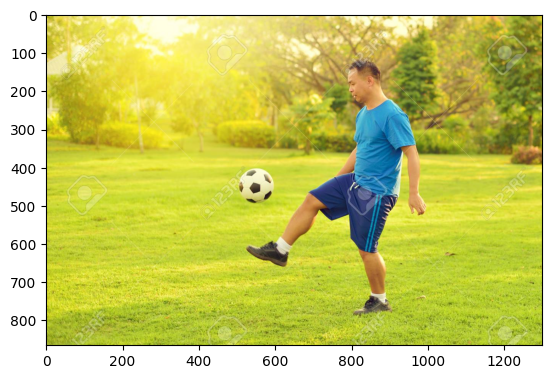

In [205]:
plt.imshow(cv2.cvtColor(cv2.imread(test_img_3), cv2.COLOR_BGR2RGB))
caption_predicted = predict_caption(test_img_3, model_resnet, tokenizer)
print(f'The predicted caption for the image is: {caption_predicted}')